<a href="https://colab.research.google.com/github/VisheshManav/mlzoomcamp-cohort-2022/blob/main/homework4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Data: [https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv)
* Course: [https://github.com/alexeygrigorev/mlbookcamp-code/tree/master/course-zoomcamp](https://github.com/alexeygrigorev/mlbookcamp-code/tree/master/course-zoomcamp)

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [3]:
data = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv"

df = pd.read_csv(data)
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [4]:
df['card'] = (df.card == 'yes').astype('int')

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']

len(df_train), len(df_val), len(df_test)

(791, 264, 264)

In [5]:
numerical = list(df.columns[(df.dtypes != 'object') & (df.columns != 'card')])
categorical = list(df.columns[(df.dtypes == 'object')])


In [6]:
numerical, categorical

(['reports',
  'age',
  'income',
  'share',
  'expenditure',
  'dependents',
  'months',
  'majorcards',
  'active'],
 ['owner', 'selfemp'])

__Q1__   
_Share has the highest auc amongst the following:_   
* _reports_
* _dependents_
* _active_
* _share_


In [7]:
for num_var in numerical:
  score = roc_auc_score(y_train, df_train[num_var])
  if score < 0.5:
    num_var_series = -df_train[num_var]
    score = roc_auc_score(y_train, num_var_series)
  print('%15s  -->  %0.3f' %(num_var, score))

        reports  -->  0.717
            age  -->  0.524
         income  -->  0.591
          share  -->  0.989
    expenditure  -->  0.991
     dependents  -->  0.533
         months  -->  0.529
     majorcards  -->  0.534
         active  -->  0.604


__Training the model__

In [8]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [9]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

__Q2__   
_0.995 is the auc of the model on validation dataset_

In [10]:
score = roc_auc_score(y_val, y_pred)
round(score, 3)

0.995

__Q3__   
_0.3 is the threshold at which precision and recall intersect_

In [11]:
scores = []

thresholds = np.linspace(0.0, 1.0, 101)

for t in thresholds:
  actual_positive = (y_val == 1)
  actual_negative = (y_val == 0)

  predict_positive = (y_pred >= t)
  predict_negative = (y_pred < t)

  tp = (predict_positive & actual_positive).sum()
  tn = (predict_negative & actual_negative).sum()

  fp = (predict_positive & actual_negative).sum()
  fn = (predict_negative & actual_positive).sum()

  scores.append((t, tp, tn, fp, fn))

cols = ['thresholds', 'tp', 'tn', 'fp', 'fn']
df_scores = pd.DataFrame(scores, columns=cols)

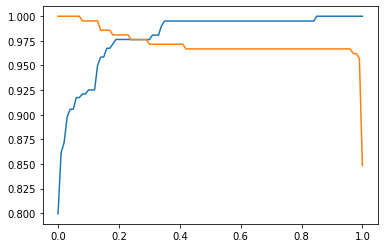

In [12]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

plt.plot(df_scores.thresholds, df_scores.p, label='precision')
plt.plot(df_scores.thresholds, df_scores.r, label='recall')
plt.show()

__Q4__   
_range(0.35, 0.42, 0.01) is the maximal value of F1 score. From the options, it is 0.4_

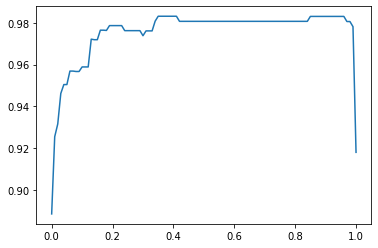

In [13]:
df_scores['f1'] = 2 * (df_scores.p * df_scores.r / (df_scores.p + df_scores.r))

plt.plot(df_scores.thresholds, df_scores.f1, label='f1')
plt.show()

In [14]:
df_scores[df_scores.f1 == df_scores.f1.max()]

,thresholds,tp,tn,fp,fn,p,r,f1
35,0.35,205,52,1,6,0.995146,0.971564,0.983213
36,0.36,205,52,1,6,0.995146,0.971564,0.983213
37,0.37,205,52,1,6,0.995146,0.971564,0.983213
38,0.38,205,52,1,6,0.995146,0.971564,0.983213
39,0.39,205,52,1,6,0.995146,0.971564,0.983213
40,0.40,205,52,1,6,0.995146,0.971564,0.983213
41,0.41,205,52,1,6,0.995146,0.971564,0.983213


In [15]:
thresholds[range(35, 42)]

array([0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41])

__Q5__   
_0.003 is the std with C=1.0_    
__Q6__   
_1 is the C as 1 and 10 have tie in both mean and std_   

In [16]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [18]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [19]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [20]:
C_values = [0.01, 0.1, 1, 10]
n_splits = 5

print('   C   | mean | std')

for C in tqdm(C_values):
  kfold = KFold(n_splits=5, shuffle=True, random_state=1)

  scores = []
  for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv, model = train(df_train, y_train, C=C)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

  print('%6s | %.3f | %.3f' % (C, np.mean(scores), np.std(scores)))

   C   | mean | std


  0%|          | 0/4 [00:00<?, ?it/s]

  0.01 | 0.992 | 0.006
   0.1 | 0.995 | 0.004
     1 | 0.996 | 0.003
    10 | 0.996 | 0.003
